In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import lsst.sims.skybrightness as sb
import numpy as np
import lsst.sims.skybrightness_pre as sbp
import healpy as hp
import lsst.sims.utils as utils
import timeit

/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Set up a grid of points, instatiate the old model
nside = 32
hpindx = np.arange(hp.nside2npix(nside))
ra, dec = utils._hpid2RaDec(nside, hpindx)

classic_model = sb.SkyModel(mags=True)

In [3]:
# Load up the new model. By default this reads in the first .npz file it finds in the sims_skybrightness_pre/data/healpix dir
new_model = sbp.SkyModelPre()

In [4]:
# Function to call the old sky brighntess code multiple times
def callClassic(sm, ra, dec, mjds):
    for mjd in mjds:
        sm.setRaDecMjd(ra, dec, mjd)
        mags = sm.returnMags()

In [5]:
# Function to call the new sky brightness code multiple times
def callNew(sm, mjds):
    for mjd in mjds:
        mags = sm.returnMags(mjd)

In [6]:
# Generate a bunch of mjd points
step = 2. /60. / 24.  # 2 minute timestep
nmjd = 200
mjds = np.arange(nmjd)*step + 59560.2+0.1

/Users/yoachim/lsst/DarwinX86/healpy/1.8.1.lsst2+1/lib/python/healpy-1.8.1-py2.7-macosx-10.6-x86_64.egg/healpy/pixelfunc.py:1045: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if phi == None:
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1.lsst2+1/lib/python/healpy-1.8.1-py2.7-macosx-10.6-x86_64.egg/healpy/pixelfunc.py:252: RuntimeWarning: invalid value encountered in less_equal
  return np.absolute(m - badval) <= atol + rtol * np.absolute(badval)
/Users/yoachim/lsst/DarwinX86/anaconda/2.2.0/lib/python2.7/site-packages/numpy/ma/core.py:2255: RuntimeWarning: invalid value encountered in less_equal
  mabs(xnew - value), atol + rtol * mabs(value))
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1.lsst2+1/lib/python/healpy-1.8.1-py2.7-macosx-10.6-x86_64.egg/healpy/projaxes.py:996: RuntimeWarning: invalid value encountered in less
  result.data[result.data<0]=0.0
/Users/yoachim/lsst/DarwinX86/healpy/1.8.1.lsst2+1/lib/python/healpy-1.8.1-py2.7-macos

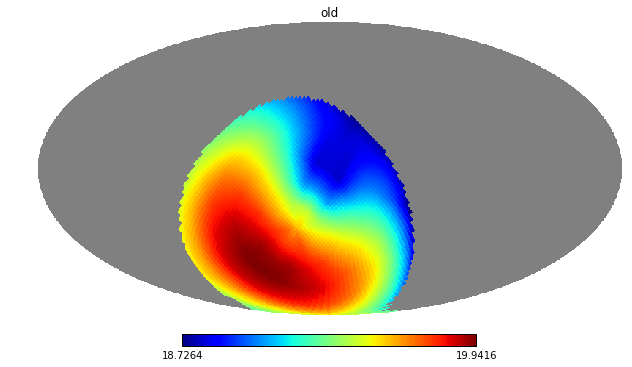

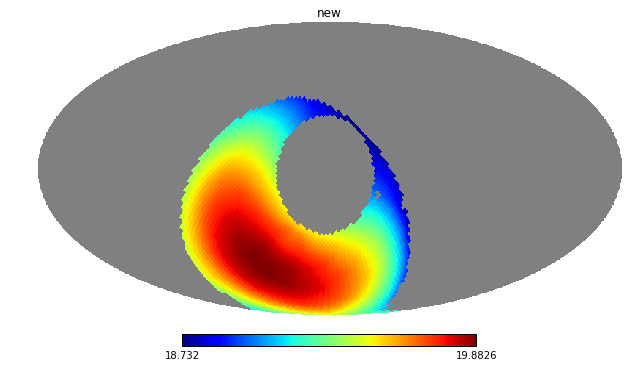

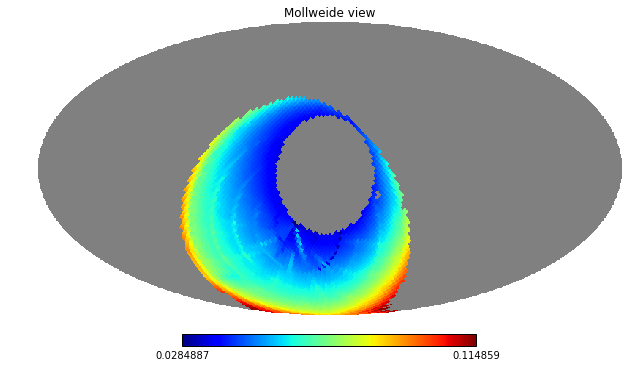

In [7]:
# Check that the results from the 2 look similar
mjd = new_model.info['mjds'][1]+.003
classic_model.setRaDecMjd(ra, dec, mjd)
mags1 = classic_model.returnMags()
hp.mollview(mags1['r'], title='old')
mags2 = new_model.returnMags(mjd)
hp.mollview(mags2['r'], title='new')
diff = mags1['r'] - mags2['r']
diff[np.where( (mags1['r'] == hp.UNSEEN) | (mags2['r'] == hp.UNSEEN))] = hp.UNSEEN
hp.mollview(diff)

Some things to note on the above plots:

* By default, the new model has masked 30 degrees around the moon and 2 degrees around a planet.
* The difference shows that the maximum difference between the two models is around 0.1 mag/sq arcsec, and that is at very high airmass, so the interpolation doesn't seem to be costing much in terms of precision.

In [8]:
# Time out the old model
time1 = timeit.timeit("callClassic(classic_model,ra ,dec, mjds)", number=1, 
                     setup="from __main__ import callClassic, classic_model,ra,dec,mjds")
print 'Classic model time = %f' % time1

Classic model time = 31.839129


In [9]:
# Time out the new model
time = timeit.timeit("callNew(new_model, mjds)", number=1, 
                     setup="from __main__ import callNew, new_model, mjds")
print 'New model time = %f' % time

New model time = 0.068641


In [10]:
print "speedup factor = %f" % (time1/time)
print "old model = %f ms per full-sky" % (time1/nmjd*1000)
print "new model = %f ms per full-sky" % (time/nmjd*1000)

speedup factor = 463.850372
old model = 159.195645 ms per full-sky
new model = 0.343205 ms per full-sky


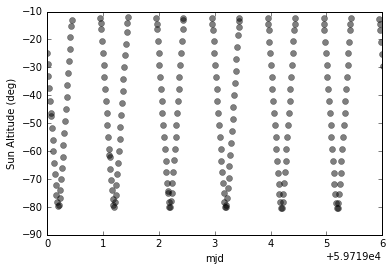

In [11]:
plt.plot(new_model.info['mjds'], np.degrees(new_model.info['sunAlts']), 'ko', alpha=.5)
plt.xlim([59719,59725])
plt.xlabel('mjd')
plt.ylabel('Sun Altitude (deg)')

In [12]:
(new_model.info['mjds'][1:]-new_model.info['mjds'][:-1])*24*60

array([  5.        ,  14.99999999,  19.99999998, ...,  19.99999998,
        19.99999998,  14.99999999])

The time step between sky models varies between 5 and 20 minutes.  Note the points get closer together in twilight since that's when the sky is changing most rapidly.  I think other close points are moon rise/set points.  

It looks like we can pre-compute ~40 sky maps per night and then interpolate between them for higher temporal resolution. 